# Comparing two descriptors: SIFT, AKAZE

In [2]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir
from os.path import isfile, join
from json import dump
import time
import pandas as pd
%matplotlib inline

In [3]:
def umat_to_mat(obj):
    return cv2.UMat.get(obj)

In [4]:
def get_metrics(path_directory, image_name, descriptor, keypoints_image_kernel, descriptors_image_kernel, 
                matcher, image_kernel, ratio=0.75):
    
    image_path = f'{path_directory}/{image_name}'
    
    print(image_path)
    metrics = {'ratio':ratio}
    
    # define start time
    time_start = time.thread_time()
    
    image = cv2.imread(image_path)
    metrics['pixels'] = image.shape[0] * image.shape[1]
    image = cv2.UMat(image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    keypoints_image, descriptors_image = descriptor.detectAndCompute(gray,None)
        
    image_features = cv2.drawKeypoints(umat_to_mat(gray),keypoints_image,umat_to_mat(image_kernel))

    # find matches
    print(f'type (descriptors_image_kernel) : {type(descriptors_image_kernel)}\n type (descriptors_image): {type(descriptors_image)}')
    matches = matcher.knnMatch(descriptors_image_kernel, descriptors_image, k=2) # sift k = 2
    
    # define end time
    time_end = time.thread_time()
    metrics['thread_time'] = time_end - time_start
    
    # compute distance
    good_matches = []
    for m, n in matches:
        if m.distance < ratio * n.distance:
            good_matches.append(m)
    
    image_maches_draw = cv2.drawMatches(image_kernel, keypoints_image_kernel, image, keypoints_image, good_matches, None)
    
    metrics['matches_good_ratio'] = len(good_matches) / np.array(matches)[:,1].shape[0]
    
    localization_errors_l1 = np.array([abs(m.distance - n.distance) for m, n in matches])
    localization_errors_l2 = np.array([np.power(m.distance - n.distance, 2) for m, n in matches])
    
    metrics['localization_error_l1_mean'] = localization_errors_l1.mean()
    metrics['localization_error_l2_mean'] = localization_errors_l2.mean()

    
    #-- Localize the object
#     obj = np.empty((len(good_matches),2), dtype=np.float32)
#     scene = np.empty((len(good_matches),2), dtype=np.float32)

#     for i in range(len(good_matches)):
#         #-- Get the keypoints from the good matches
#         obj[i,0] = keypoints_image_kernel[good_matches[i].queryIdx].pt[0]
#         obj[i,1] = keypoints_image_kernel[good_matches[i].queryIdx].pt[1]
#         scene[i,0] = keypoints_image[good_matches[i].trainIdx].pt[0]
#         scene[i,1] = keypoints_image[good_matches[i].trainIdx].pt[1]
    
#     H, _ =  cv2.findHomography(obj, scene, cv2.RANSAC)
    
#     # print(type(H))
#     if H is None :
#         metrics['loc_error_norm_of_homography_matrix'] = 0
#     else:
#         metrics['loc_error_norm_of_homography_matrix'] = np.linalg.norm(H)
    
    return metrics, image_features, umat_to_mat(image_maches_draw)

In [6]:
def define_metrics(descriptor_name, directory_train_name, json_dump_name, name_directory_dump, ratio=0.75, saved_dump=True):
    '''
    descriptor_name - SIFT, AKAZE string format,
    directory_train_name - string format name of directory,
    json_dump_name - string format name of json_dump
    '''
    metrics_images = {}

    
    path_directory = os.path.abspath(os.getcwd())
    path_directory_image = f'{path_directory}/{directory_train_name}'
    
    path_features = f'{directory_train_name}_{descriptor_name}'
    path_features_compared = f'{directory_train_name}_{descriptor_name}_compared'
    try:
        os.mkdir(path_features)
        os.mkdir(path_features_compared)
        os.mkdir(name_directory_dump)
        
    except FileExistsError:
            pass
    
    all_training_set = np.array([f for f in listdir(path_directory_image) if isfile(join(path_directory_image, f))])
    all_training_set = np.sort(all_training_set)
    
    
    path_kernel_image = f'{path_directory_image}/{all_training_set[0]}'
    
    print(f'kernel : {path_kernel_image}')
    image_kernel = cv2.imread(path_kernel_image) 
    
    # Turn on GPU
    image_kernel = cv2.UMat(image_kernel)
    
    gray_image_kernel = cv2.cvtColor(image_kernel, cv2.COLOR_BGR2GRAY)
        
    if descriptor_name == 'sift':
        print('sift')
        descriptor = cv2.xfeatures2d.SIFT_create()
        matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
        
    elif descriptor_name == 'akaze':
        print('akaze')
        descriptor = cv2.AKAZE_create()
        matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_BRUTEFORCE_HAMMING)

    else:
        pass
    
    keypoints_image_kernel, descriptors_image_kernel = descriptor.detectAndCompute(gray_image_kernel,None)
    
    for image_file_name in all_training_set[1:]:

        metrics, image_features, image_maches_draw  = get_metrics(path_directory_image, image_file_name, descriptor, keypoints_image_kernel, descriptors_image_kernel,
                              matcher, image_kernel, ratio)
        metrics_images[image_file_name] = metrics
        
        cv2.imwrite(f'{path_features}/{image_file_name}', image_features)
        cv2.imwrite(f'{path_features_compared}/{image_file_name}', image_maches_draw)

    
    if saved_dump:
        with open(f'{name_directory_dump}/{json_dump_name}.json', 'w') as f:
            dump(metrics_images, f, indent=4)
    
    return metrics_images

In [9]:
descriptor_name='sift'
directory_train_name='training_sandglass'
json_dump_name='sandglass_sift'
name_directory_dump = 'sandglass_train_dump'

define_metrics(descriptor_name, directory_train_name, json_dump_name, name_directory_dump)

kernel : /home/eduard/gitRepo/object_recognition/Lab2/training_sandglass/sandglass_1.jpg
sift
/home/eduard/gitRepo/object_recognition/Lab2/training_sandglass/sandglass_10.jpg
type (descriptors_image_kernel) : <class 'cv2.UMat'>
 type (descriptors_image): <class 'cv2.UMat'>
/home/eduard/gitRepo/object_recognition/Lab2/training_sandglass/sandglass_11.jpg
type (descriptors_image_kernel) : <class 'cv2.UMat'>
 type (descriptors_image): <class 'cv2.UMat'>
/home/eduard/gitRepo/object_recognition/Lab2/training_sandglass/sandglass_12.jpg
type (descriptors_image_kernel) : <class 'cv2.UMat'>
 type (descriptors_image): <class 'cv2.UMat'>
/home/eduard/gitRepo/object_recognition/Lab2/training_sandglass/sandglass_13.jpg
type (descriptors_image_kernel) : <class 'cv2.UMat'>
 type (descriptors_image): <class 'cv2.UMat'>
/home/eduard/gitRepo/object_recognition/Lab2/training_sandglass/sandglass_14.jpg
type (descriptors_image_kernel) : <class 'cv2.UMat'>
 type (descriptors_image): <class 'cv2.UMat'>
/home/

type (descriptors_image_kernel) : <class 'cv2.UMat'>
 type (descriptors_image): <class 'cv2.UMat'>
/home/eduard/gitRepo/object_recognition/Lab2/training_sandglass/sandglass_63.jpg
type (descriptors_image_kernel) : <class 'cv2.UMat'>
 type (descriptors_image): <class 'cv2.UMat'>
/home/eduard/gitRepo/object_recognition/Lab2/training_sandglass/sandglass_64.jpg
type (descriptors_image_kernel) : <class 'cv2.UMat'>
 type (descriptors_image): <class 'cv2.UMat'>
/home/eduard/gitRepo/object_recognition/Lab2/training_sandglass/sandglass_65.jpg
type (descriptors_image_kernel) : <class 'cv2.UMat'>
 type (descriptors_image): <class 'cv2.UMat'>
/home/eduard/gitRepo/object_recognition/Lab2/training_sandglass/sandglass_66.jpg
type (descriptors_image_kernel) : <class 'cv2.UMat'>
 type (descriptors_image): <class 'cv2.UMat'>
/home/eduard/gitRepo/object_recognition/Lab2/training_sandglass/sandglass_67.jpg
type (descriptors_image_kernel) : <class 'cv2.UMat'>
 type (descriptors_image): <class 'cv2.UMat'>
/

{'sandglass_10.jpg': {'ratio': 0.75,
  'pixels': 16064064,
  'thread_time': 2.5399861160000228,
  'matches_good_ratio': 0.05894736842105263,
  'localization_error_l1_mean': 19.538327620656865,
  'localization_error_l2_mean': 894.5556699184009},
 'sandglass_11.jpg': {'ratio': 0.75,
  'pixels': 16064064,
  'thread_time': 2.4997360510000135,
  'matches_good_ratio': 0.05052631578947368,
  'localization_error_l1_mean': 19.04614423249897,
  'localization_error_l2_mean': 862.5517979725287},
 'sandglass_12.jpg': {'ratio': 0.75,
  'pixels': 16064064,
  'thread_time': 2.556157741999982,
  'matches_good_ratio': 0.04421052631578947,
  'localization_error_l1_mean': 20.093923877916836,
  'localization_error_l2_mean': 952.9416459792486},
 'sandglass_13.jpg': {'ratio': 0.75,
  'pixels': 16064064,
  'thread_time': 2.5053156099999683,
  'matches_good_ratio': 0.1031578947368421,
  'localization_error_l1_mean': 31.22145119114926,
  'localization_error_l2_mean': 1721.2153508600504},
 'sandglass_14.jpg': {'

In [8]:
descriptor_name='akaze'
directory_train_name='training_sandglass'
json_dump_name='sandglass_akaze'
name_directory_dump = 'sandglass_train_dump'

define_metrics(descriptor_name, directory_train_name, json_dump_name, name_directory_dump)

kernel : /home/eduard/gitRepo/object_recognition/Lab2/training_sandglass/sandglass_1.jpg
akaze
/home/eduard/gitRepo/object_recognition/Lab2/training_sandglass/sandglass_10.jpg
type (descriptors_image_kernel) : <class 'cv2.UMat'>
 type (descriptors_image): <class 'cv2.UMat'>
/home/eduard/gitRepo/object_recognition/Lab2/training_sandglass/sandglass_11.jpg
type (descriptors_image_kernel) : <class 'cv2.UMat'>
 type (descriptors_image): <class 'cv2.UMat'>
/home/eduard/gitRepo/object_recognition/Lab2/training_sandglass/sandglass_12.jpg
type (descriptors_image_kernel) : <class 'cv2.UMat'>
 type (descriptors_image): <class 'cv2.UMat'>
/home/eduard/gitRepo/object_recognition/Lab2/training_sandglass/sandglass_13.jpg
type (descriptors_image_kernel) : <class 'cv2.UMat'>
 type (descriptors_image): <class 'cv2.UMat'>
/home/eduard/gitRepo/object_recognition/Lab2/training_sandglass/sandglass_14.jpg
type (descriptors_image_kernel) : <class 'cv2.UMat'>
 type (descriptors_image): <class 'cv2.UMat'>
/home

type (descriptors_image_kernel) : <class 'cv2.UMat'>
 type (descriptors_image): <class 'cv2.UMat'>
/home/eduard/gitRepo/object_recognition/Lab2/training_sandglass/sandglass_63.jpg
type (descriptors_image_kernel) : <class 'cv2.UMat'>
 type (descriptors_image): <class 'cv2.UMat'>
/home/eduard/gitRepo/object_recognition/Lab2/training_sandglass/sandglass_64.jpg
type (descriptors_image_kernel) : <class 'cv2.UMat'>
 type (descriptors_image): <class 'cv2.UMat'>
/home/eduard/gitRepo/object_recognition/Lab2/training_sandglass/sandglass_65.jpg
type (descriptors_image_kernel) : <class 'cv2.UMat'>
 type (descriptors_image): <class 'cv2.UMat'>
/home/eduard/gitRepo/object_recognition/Lab2/training_sandglass/sandglass_66.jpg
type (descriptors_image_kernel) : <class 'cv2.UMat'>
 type (descriptors_image): <class 'cv2.UMat'>
/home/eduard/gitRepo/object_recognition/Lab2/training_sandglass/sandglass_67.jpg
type (descriptors_image_kernel) : <class 'cv2.UMat'>
 type (descriptors_image): <class 'cv2.UMat'>
/

{'sandglass_10.jpg': {'ratio': 0.75,
  'pixels': 16064064,
  'thread_time': 1.4815821109999945,
  'matches_good_ratio': 0.07674418604651163,
  'localization_error_l1_mean': 8.851162790697675,
  'localization_error_l2_mean': 154.52558139534884},
 'sandglass_11.jpg': {'ratio': 0.75,
  'pixels': 16064064,
  'thread_time': 1.4747361489999946,
  'matches_good_ratio': 0.07441860465116279,
  'localization_error_l1_mean': 9.195348837209302,
  'localization_error_l2_mean': 163.67906976744186},
 'sandglass_12.jpg': {'ratio': 0.75,
  'pixels': 16064064,
  'thread_time': 1.4527079199999946,
  'matches_good_ratio': 0.037209302325581395,
  'localization_error_l1_mean': 7.869767441860465,
  'localization_error_l2_mean': 134.77209302325582},
 'sandglass_13.jpg': {'ratio': 0.75,
  'pixels': 16064064,
  'thread_time': 1.4772135030000015,
  'matches_good_ratio': 0.027906976744186046,
  'localization_error_l1_mean': 7.27906976744186,
  'localization_error_l2_mean': 103.1906976744186},
 'sandglass_14.jpg':

# Working with metrics

In [11]:
file_name_json_sift = 'sandglass_train_dump/sandglass_sift.json'
file_name_json_akaze = 'sandglass_train_dump/sandglass_akaze.json'
metrices_sift = pd.read_json(file_name_json_sift)
metrices_akaze = pd.read_json(file_name_json_akaze)

metrices_sift = metrices_sift.T
metrices_akaze = metrices_akaze.T

In [12]:
metrices_sift

,ratio,pixels,thread_time,matches_good_ratio,localization_error_l1_mean,localization_error_l2_mean
sandglass_10.jpg,0.75,16064064.0,2.539986,0.058947,19.538328,894.555670
sandglass_11.jpg,0.75,16064064.0,2.499736,0.050526,19.046144,862.551798
sandglass_12.jpg,0.75,16064064.0,2.556158,0.044211,20.093924,952.941646
sandglass_13.jpg,0.75,16064064.0,2.505316,0.103158,31.221451,1721.215351
sandglass_14.jpg,0.75,16064064.0,2.557816,0.216842,45.377040,3921.980997
...,...,...,...,...,...,...
sandglass_78.jpg,0.75,16064064.0,2.716929,0.037895,15.655334,582.194956
sandglass_79.jpg,0.75,16064064.0,2.687720,0.014737,13.742951,366.028911
sandglass_8.jpg,0.75,16064064.0,2.535141,0.037895,25.720951,1306.531401
sandglass_80.jpg,0.75,15996752.0,2.536738,0.025263,23.615181,1046.782228


In [13]:
metrices_akaze

,ratio,pixels,thread_time,matches_good_ratio,localization_error_l1_mean,localization_error_l2_mean
sandglass_10.jpg,0.75,16064064.0,1.481582,0.076744,8.851163,154.525581
sandglass_11.jpg,0.75,16064064.0,1.474736,0.074419,9.195349,163.679070
sandglass_12.jpg,0.75,16064064.0,1.452708,0.037209,7.869767,134.772093
sandglass_13.jpg,0.75,16064064.0,1.477214,0.027907,7.279070,103.190698
sandglass_14.jpg,0.75,16064064.0,1.497960,0.037209,8.344186,138.400000
...,...,...,...,...,...,...
sandglass_78.jpg,0.75,16064064.0,1.594028,0.006977,5.106977,46.460465
sandglass_79.jpg,0.75,16064064.0,1.540851,0.006977,5.072093,50.583721
sandglass_8.jpg,0.75,16064064.0,1.473637,0.032558,8.790698,153.376744
sandglass_80.jpg,0.75,15996752.0,1.459685,0.027907,9.906977,186.851163


## Plots

- **red** collor - SIFT 
- **blue** collor - AKAZE

In [14]:
def create_curves_for_tabel(feature_1, feature_2, metrices_sift, metrices_akaze):
    plt.plot(metrices_sift[feature_1], metrices_sift[feature_2], '-', color='red', label='SIFT')
    plt.plot(metrices_akaze[feature_1], metrices_akaze[feature_2], '-', color='blue', label='AKAZE')
    plt.xlabel(feature_1)
    plt.ylabel(feature_2)
    plt.grid(True)
    plt.title(f'{feature_1} - {feature_2}')
    plt.show()
    plt.close()

In [15]:
def create_curves_vectors(feature_1, feature_2, x_label, y_label_swift, y_label_akaze):
    plt.plot(x_label, y_label_swift, '-', color='red', label='sift')
    plt.plot(x_label, y_label_akaze, '-', color='blue', label='akaze')
    plt.xlabel(feature_1)
    plt.ylabel(feature_2)
    plt.grid(True)
    plt.title(f'{feature_1} - {feature_2}')
        
    plt.show()
    plt.close()

### Pixels - time
- **red** collor - SIFT 
- **blue** collor - AKAZE

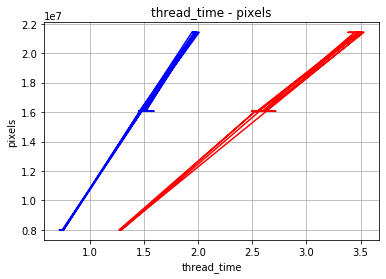

In [16]:
feature_1 = 'thread_time'
feature_2 = 'pixels'
create_curves_for_tabel(feature_1, feature_2, metrices_sift, metrices_akaze)

### Picture - matches_good_ratio
- **red** collor - SIFT 
- **blue** collor - AKAZE

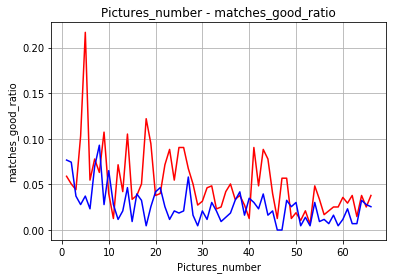

In [17]:
x_label = [x for x in range(1,metrices_sift.shape[0] + 1)]

y_label_swift = metrices_sift['matches_good_ratio']
y_label_akaze = metrices_akaze['matches_good_ratio']

feature_1 = 'Pictures_number'
feature_2 = 'matches_good_ratio'

create_curves_vectors(feature_1, feature_2, x_label, y_label_swift, y_label_akaze)

### Picture - thread_time
- **red** collor - SIFT 
- **blue** collor - AKAZE

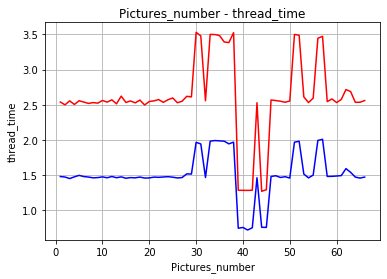

In [18]:
x_label = [x for x in range(1,metrices_sift.shape[0] + 1)]

y_label_swift = metrices_sift['thread_time']
y_label_akaze = metrices_akaze['thread_time']

feature_1 = 'Pictures_number'
feature_2 = 'thread_time'

create_curves_vectors(feature_1, feature_2, x_label, y_label_swift, y_label_akaze)

### Picture - localization_error_l1_mean
- **red** collor - SIFT 
- **blue** collor - AKAZE

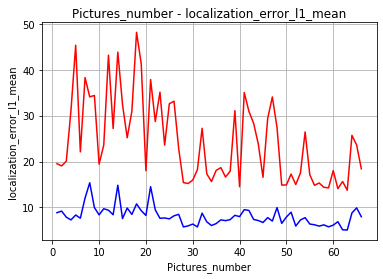

In [19]:
x_label = [x for x in range(1,metrices_sift.shape[0] + 1)]

y_label_swift = metrices_sift['localization_error_l1_mean']
y_label_akaze = metrices_akaze['localization_error_l1_mean']

feature_1 = 'Pictures_number'
feature_2 = 'localization_error_l1_mean'

create_curves_vectors(feature_1, feature_2, x_label, y_label_swift, y_label_akaze)

### Picture - localization_error_l2_mean
- **red** collor - SIFT 
- **blue** collor - AKAZE

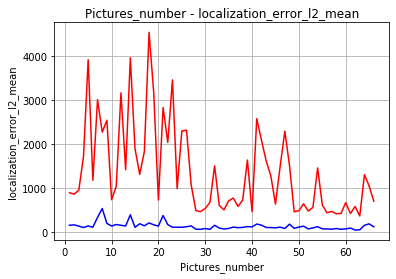

In [20]:
x_label = [x for x in range(1,metrices_sift.shape[0] + 1)]

y_label_swift = metrices_sift['localization_error_l2_mean']
y_label_akaze = metrices_akaze['localization_error_l2_mean']

feature_1 = 'Pictures_number'
feature_2 = 'localization_error_l2_mean'

create_curves_vectors(feature_1, feature_2, x_label, y_label_swift, y_label_akaze)

# Concluzions